## FM Acquisition Example

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from fibsem.fm.structures import ChannelSettings, ZParameters, FluorescenceImage
from fibsem.fm.acquisition import acquire_channels, acquire_z_stack, acquire_image
from fibsem.fm.calibration import run_autofocus, run_coarse_fine_autofocus, run_multi_position_autofocus

from fibsem.fm.microscope import FluorescenceMicroscope
# other microscopes can be imported as needed
# from fibsem.fm.thermo_fisher import ThermoFisherFluorescenceMicroscope
# from fibsem.fm.odemis import OdemisFluorescenceMicroscope # -> NOTE: only works on odemis pc

# create microscope 
fm = FluorescenceMicroscope()
# fm = OdemisFluorescenceMicroscope(None)
# fm = ThermoFisherFluorescenceMicroscope()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# parameters
print("Camera")
print(f"Exposure time: {fm.camera.exposure_time} s")
print(f"Pixel size: {fm.camera.pixel_size} um")
print(f"Resolution: {fm.camera.resolution} px")
print(f"Field of view: {fm.camera.field_of_view} um")

print("Filter Wheel")
print(f"Excitation wavelength: {fm.filter_set.excitation_wavelength} nm")
print(f"Available excitation wavelengths: {fm.filter_set.available_excitation_wavelengths}")
print(f"Emission wavelength: {fm.filter_set.emission_wavelength} nm")
print(f"Available emission wavelengths: {fm.filter_set.available_emission_wavelengths}")

print("Light Source")
print(f"Power: {fm.light_source.power} W")

Camera
Exposure time: 0.1 s
Pixel size: (1e-07, 1e-07) um
Resolution: (512, 512) px
Field of view: (5.12e-05, 5.12e-05) um
Filter Wheel
Excitation wavelength: 365 nm
Available excitation wavelengths: (365, 450, 550, 635)
Emission wavelength: None nm
Available emission wavelengths: (365, 450, 550, 635, None)
Light Source
Power: 0.1 W


In [13]:
# Channel settings 
channel_settings = ChannelSettings(
    name="Channel-01", 
    excitation_wavelength=405, 
    emission_wavelength=None,  # None -> reflection 
    exposure_time=0.01, 
    power=0.01)

# set the channel settings
fm.set_channel(channel_settings)

# also can be set indiviudally
fm.camera.exposure_time = 0.01

In [14]:
# QUERY: what is the best way to set emission wavelength?
# TFS: has mutlti-filter so you only set FLUORESCENCE/REFLECTION
# Odemis: has single filter so you set excitation and emission wavelength

# in practice, you'd always set the emission based on the excitation wavelength, so 
# is  it worth having a separate emission wavelength setting? aside from FL/REFLECTION


#### Objective Controls

In [16]:
# insert objective
fm.objective.insert()

2025-07-15 18:00:51,352 — root — INFO — move_absolute:107 — Objective moved to absolute position: 0.0
2025-07-15 18:00:51,353 — root — INFO — insert:116 — Objective lens inserted to position: 0.0


In [17]:
# objective (lens) control
print(f"Objective Position: {fm.objective.position}")

Objective Position: 0.0


In [18]:
# move relative
print(f"Objective Position: {fm.objective.position}")
fm.objective.move_relative(10e-6)  # move 10 microns
print(f"Objective Position: {fm.objective.position}")

Objective Position: 0.0
2025-07-15 18:01:00,861 — root — INFO — move_relative:98 — Objective moved to new position: 1e-05 (delta: 1e-05)
Objective Position: 1e-05


In [19]:
# move absolute
# fm.objective.move_absolute(0)
print(f"Objective Position: {fm.objective.position}")

Objective Position: 1e-05


In [20]:
# retract objective
fm.objective.retract()

2025-07-15 18:01:06,249 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.01
2025-07-15 18:01:06,250 — root — INFO — retract:125 — Objective lens retracted to position: -0.01


#### Image Acquisition

Image Shape: (512, 512)


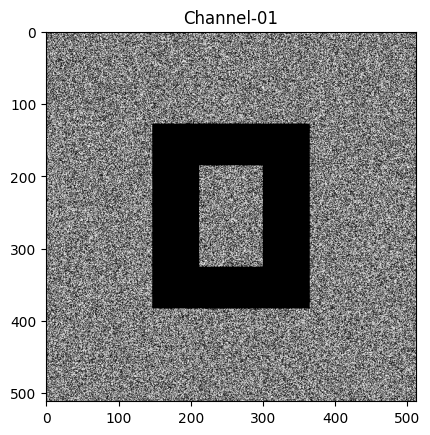

In [21]:
# single channel acquisition, uses the current microscope settings
image = fm.acquire_image()

# 2D Image (YX)
print(f"Image Shape: {image.data.shape}")

plt.imshow(image.data, cmap='gray')
plt.title(image.metadata.channels[0].name)
plt.show()


In [22]:
image.metadata.pixel_size_x

1e-07

In [23]:
# metadata
print("Image Metadata:")
pprint(image.metadata.to_dict())


# metadata: FluorescenceImageMetadata
#     channels: List[FluorescenceChannelMetadata]

Image Metadata:
{'acquisition_date': '2025-07-15T18:01:11.564302',
 'channel_count': 1,
 'channels': [{'binning': 1,
               'emission_wavelength': None,
               'excitation_wavelength': 405,
               'exposure_time': 0.01,
               'gain': 1.0,
               'name': 'Channel-01',
               'objective_magnification': 100.0,
               'objective_numerical_aperture': 0.8,
               'objective_position': -0.01,
               'offset': 0.0,
               'power': 0.01}],
 'description': None,
 'filename': None,
 'pixel_size_x': 1e-07,
 'pixel_size_y': 1e-07,
 'pixel_size_z': None,
 'resolution': (512, 512),
 'stage_position': None,
 'system_info': None,
 'z_count': 1,
 'z_positions': None}


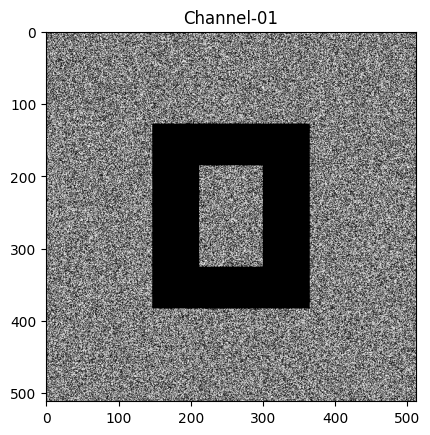

In [24]:
# save image (ome-tiff format)
filename = "test-image.ome.tiff"
image.save(filename)

# load image
loaded_image = FluorescenceImage.load(filename) # always loaded as CZYX

# plot loaded image
plt.imshow(loaded_image.data[0, 0], cmap='gray')
plt.title(loaded_image.metadata.channels[0].name)
plt.show()

Image Shape: (2, 1, 512, 512)


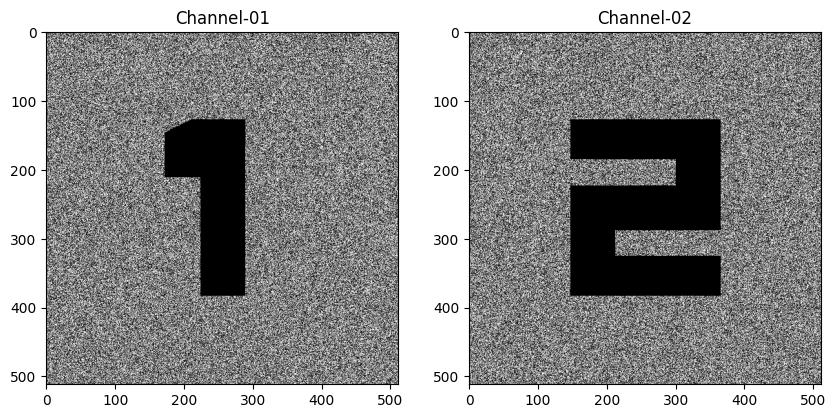

In [25]:
# multi-channel acquisition
channel_settings = [
    ChannelSettings(
        name="Channel-01",
        excitation_wavelength=405,
        emission_wavelength=None,
        exposure_time=0.01,
        power=0.01),
    ChannelSettings(
        name="Channel-02",
        excitation_wavelength=405,
        emission_wavelength=405,
        exposure_time=0.02,
        power=0.02)
]

image = acquire_channels(fm, channel_settings)

# 4D Image (CZYX)
print(f"Image Shape: {image.data.shape}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.data[0, 0, :, :], cmap='gray')
axes[0].set_title(image.metadata.channels[0].name)
axes[1].imshow(image.data[1, 0, :, :], cmap='gray')
axes[1].set_title(image.metadata.channels[1].name)

plt.show()

In [26]:
# generate z-parameters (objective positions)
zparams = ZParameters(zmin=-2e-6, zmax=2e-6, zstep=1e-6)

zpositions = zparams.generate_positions(z_init=fm.objective.position)
print(f"Z-Positions: {zpositions}")

Z-Positions: [-0.010002, -0.010001000000000001, -0.010000000000000002, -0.009999000000000003, -0.009998000000000003]


2025-07-15 18:01:26,707 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.010002
2025-07-15 18:01:26,951 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.010001000000000001
2025-07-15 18:01:27,141 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.010000000000000002
2025-07-15 18:01:27,409 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.009999000000000003
2025-07-15 18:01:27,713 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.009998000000000003
2025-07-15 18:01:27,861 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.010002
2025-07-15 18:01:28,223 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.010001000000000001
2025-07-15 18:01:28,535 — root — INFO — move_absolute:107 — Objective moved to absolute position: -0.010000000000000002
2025-07-15 18:01:28,557 — root — INFO — move_absolute:107 — Obje

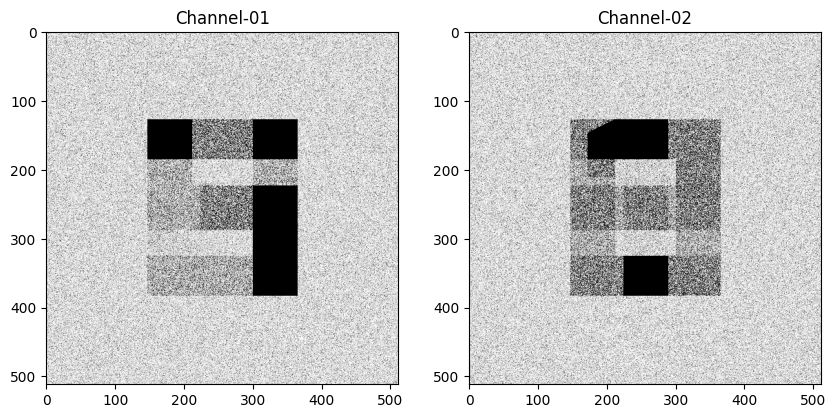

In [27]:
# acquire a z-stack
# NOTE: make sure the objective is inserted and in a safe position
image  = acquire_z_stack(fm, channel_settings, zparams)

# 4D Image (CZXY)
print(f"Image Shape: {image.data.shape}")

# plot the maximum intensity projection for each channel
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.max(image.data[0, :, :, :], axis=0), cmap='gray')
axes[0].set_title(image.metadata.channels[0].name)
axes[1].imshow(np.max(image.data[1, :, :, :], axis=0), cmap='gray')
axes[1].set_title(image.metadata.channels[1].name)

plt.show()

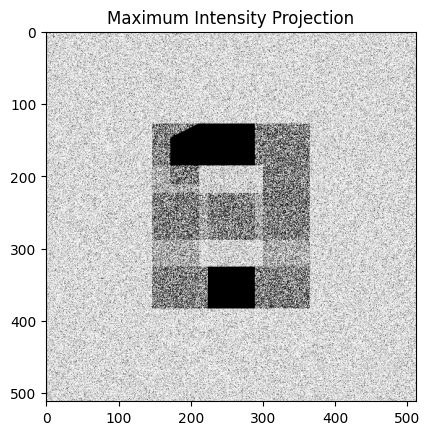

In [28]:
mip = image.max_intensity_projection(channel=1, return_2d=True)
plt.imshow(mip, cmap='gray')
plt.title("Maximum Intensity Projection")
plt.show()

Focus Stack Shape: (2, 1, 512, 512)


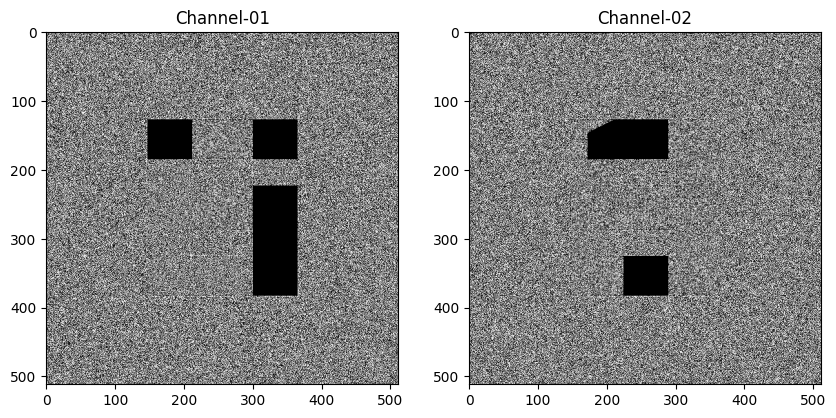

In [29]:
focus_stack = image.focus_stack()

print(f"Focus Stack Shape: {focus_stack.data.shape}")

# plot the focus stack
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(focus_stack.data[0, 0, :, :], cmap='gray')
axes[0].set_title(focus_stack.metadata.channels[0].name)
axes[1].imshow(focus_stack.data[1, 0, :, :], cmap='gray')
axes[1].set_title(focus_stack.metadata.channels[1].name)
plt.show()


#### Live Acquisition

In [30]:
import time

def on_acquisition_signal(image: FluorescenceImage):
    print("Acquisition signal received!")
    print(f"Image shape: {image.data.shape}")
    print(f"Acquisition Date: {image.metadata.acquisition_date}")
    print(f"Channel Name: {image.metadata.channels[0].name}")
    print(f"Excitation Power: {image.metadata.channels[0].power} W")
    print(f"Exposure Time: {image.metadata.channels[0].exposure_time} s")
    print(f"Excitation Wavelength: {image.metadata.channels[0].excitation_wavelength} nm")
    print(f"Emission Wavelength: {image.metadata.channels[0].emission_wavelength} nm")
    print(f"Objective Magnification: {image.metadata.channels[0].objective_magnification}x")
    print(f"Objective Position: {image.metadata.channels[0].objective_position:.2e} m")
    print(f"Image Data Type: {image.data.dtype}")
    print("-"*80)
    # plt.imshow(image.data, cmap='gray')
    # plt.show()

# acquisition emits a FluorescenceImage signal once image is acquire, can be subscribed to
fm.acquisition_signal.disconnect() # disconnect any previous connections
fm.acquisition_signal.connect(on_acquisition_signal)

fm.set_exposure_time(0.05)

In [31]:
# start the acquisition
fm.start_acquisition()

time.sleep(5)

# stop acquisition
fm.stop_acquisition()

2025-07-15 18:01:39,162 — root — INFO — _acquisition_worker:690 — Starting acquisition worker thread.
Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:01:39.215865
Channel Name: Channel-02
Excitation Power: 0.02 W
Exposure Time: 0.05 s
Excitation Wavelength: 405 nm
Emission Wavelength: 405 nm
Objective Magnification: 100.0x
Objective Position: -1.00e-02 m
Image Data Type: uint16
--------------------------------------------------------------------------------
Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:01:39.267277
Channel Name: Channel-02
Excitation Power: 0.02 W
Exposure Time: 0.05 s
Excitation Wavelength: 405 nm
Emission Wavelength: 405 nm
Objective Magnification: 100.0x
Objective Position: -1.00e-02 m
Image Data Type: uint16
--------------------------------------------------------------------------------
Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:01:39.320604
Channe

#### AutoFocus

Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:02:02.129406
Channel Name: Channel-01
Excitation Power: 0.01 W
Exposure Time: 0.01 s
Excitation Wavelength: 405 nm
Emission Wavelength: None nm
Objective Magnification: 100.0x
Objective Position: -1.00e-02 m
Image Data Type: uint16
--------------------------------------------------------------------------------
Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:02:02.150538
Channel Name: Channel-02
Excitation Power: 0.02 W
Exposure Time: 0.02 s
Excitation Wavelength: 405 nm
Emission Wavelength: 405 nm
Objective Magnification: 100.0x
Objective Position: -1.00e-02 m
Image Data Type: uint16
--------------------------------------------------------------------------------
2025-07-15 18:02:02,151 — root — INFO — run_autofocus:673 — Starting autofocus: 8 positions, method='laplacian'
2025-07-15 18:02:02,151 — root — INFO — move_absolute:107 — Objective moved to absolute posit

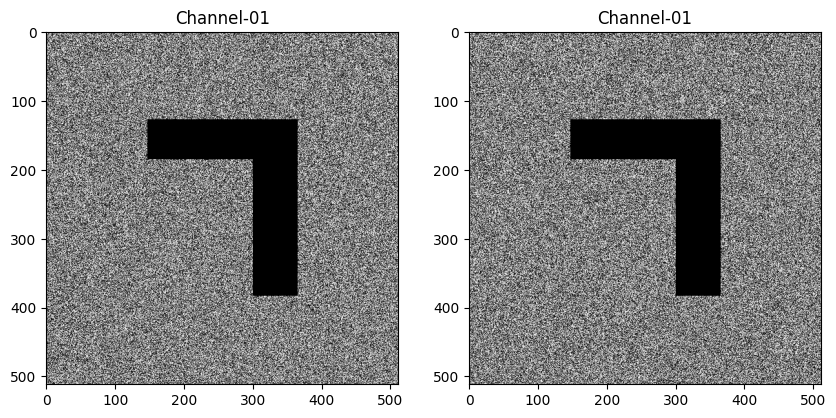

In [32]:
# NOTE: make sure the objective is inserted, and safe before running autofocus
image1 = acquire_image(fm, channel_settings)
best_focus_position = run_autofocus(fm)
print(f"Best Focus Position: {best_focus_position}")

image2 = acquire_image(fm, channel_settings)

# plot the acquired images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1.data[0, 0, :, :], cmap='gray')
axes[0].set_title(image1.metadata.channels[0].name)
axes[1].imshow(image2.data[0, 0, :, :], cmap='gray')
axes[1].set_title(image2.metadata.channels[0].name)

plt.show()

Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:02:07.195946
Channel Name: Channel-01
Excitation Power: 0.01 W
Exposure Time: 0.01 s
Excitation Wavelength: 405 nm
Emission Wavelength: None nm
Objective Magnification: 100.0x
Objective Position: -1.00e-02 m
Image Data Type: uint16
--------------------------------------------------------------------------------
Acquisition signal received!
Image shape: (512, 512)
Acquisition Date: 2025-07-15T18:02:07.216892
Channel Name: Channel-02
Excitation Power: 0.02 W
Exposure Time: 0.02 s
Excitation Wavelength: 405 nm
Emission Wavelength: 405 nm
Objective Magnification: 100.0x
Objective Position: -1.00e-02 m
Image Data Type: uint16
--------------------------------------------------------------------------------
2025-07-15 18:02:07,217 — root — INFO — run_coarse_fine_autofocus:750 — Starting two-stage autofocus from -10005.0 μm
2025-07-15 18:02:07,217 — root — INFO — run_coarse_fine_autofocus:753 — Coarse search: 

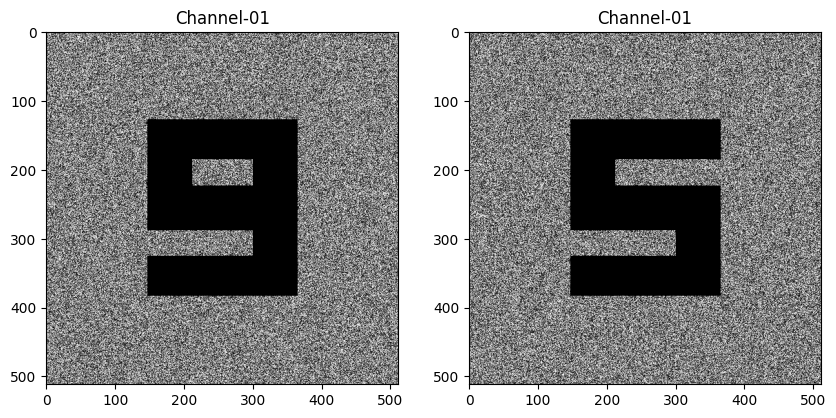

In [33]:
# NOTE: make sure the objective is inserted, and safe before running autofocus
image1 = acquire_channels(fm, channel_settings)

best_focus_position = run_coarse_fine_autofocus(fm)
print(f"Best Focus Position: {best_focus_position}")

image2 = acquire_channels(fm, channel_settings)

# plot the acquired images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1.data[0, 0, :, :], cmap='gray')
axes[0].set_title(image1.metadata.channels[0].name)
axes[1].imshow(image2.data[0, 0, :, :], cmap='gray')
axes[1].set_title(image2.metadata.channels[0].name)

plt.show()

In [34]:
# requires integrated fibsem/fm microscope
from fibsem import utils
from fibsem.structures import BeamType
microscope, settings = utils.setup_session()


# create some test positions (project-stable-move)
current_position = microscope.get_stage_position()
stages_positions = [
    microscope.project_stable_move(dx=-50e-6, dy=-50e-6, beam_type=BeamType.ELECTRON, base_position=current_position),
    microscope.project_stable_move(dx=50e-6, dy=-50e-6, beam_type=BeamType.ELECTRON, base_position=current_position),
    microscope.project_stable_move(dx=0, dy=0, beam_type=BeamType.ELECTRON, base_position=current_position),
    microscope.project_stable_move(dx=-50e-6, dy=50e-6, beam_type=BeamType.ELECTRON, base_position=current_position),
    microscope.project_stable_move(dx=50e-6, dy=50e-6, beam_type=BeamType.ELECTRON, base_position=current_position),
]

# set names for the positions
stages_positions[0].name = "top-left"
stages_positions[1].name = "top-right"
stages_positions[2].name = "center"
stages_positions[3].name = "bottom-left"
stages_positions[4].name = "bottom-right"

# run multi-position autofocus
# focus_map = run_multi_position_autofocus(microscope, stages_positions, return_to_start=True)



2025-07-15 18:02:17,733 — root — INFO — _setup_image_iterators:447 — SEM or FIB data path not configured in simulator settings, using random noise generation
2025-07-15 18:02:17,734 — root — INFO — connect_to_microscope:277 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2025-07-15 18:02:17,734 — root — INFO — setup_session:268 — Finished setup for session: demo_2025-07-15-06-02-17PM


#### Overview Acquisition

In [35]:
%load_ext autoreload
%autoreload 2


from fibsem import utils
from fibsem.fm.acquisition import acquire_tileset, ChannelSettings, acquire_and_stitch_tileset, ZParameters, stitch_tileset, AutofocusMode
from fibsem.structures import BeamType
import matplotlib.pyplot as plt
from pprint import pprint


microscope, settings = utils.setup_session()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2025-07-15 18:02:27,811 — root — INFO — _setup_image_iterators:447 — SEM or FIB data path not configured in simulator settings, using random noise generation
2025-07-15 18:02:27,812 — root — INFO — connect_to_microscope:277 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2025-07-15 18:02:27,812 — root — INFO — setup_session:268 — Finished setup for session: demo_2025-07-15-06-02-27PM


In [36]:
channel_settings = ChannelSettings(
    name="Channel-01",
    excitation_wavelength=488.0,
    emission_wavelength=None,
    power=0.1,
    exposure_time=0.1,
)

# To acquire a tileset on arctis:
# pre-tilt = 0
# orientation=FM
# beam_type=BeamType.ELECTRON

microscope.system.stage.shuttle_pre_tilt = 0
microscope.stage_is_compustage = True
# microscope.move_flat_to_beam(beam_type=BeamType.ELECTRON)
print(f"Stage Position: {microscope.get_stage_position()}")
print(f"Stage Orientation: {microscope.get_stage_orientation()}")
print(f"FM Objective Position: {microscope.fm.objective.position}")
beam_type = BeamType.ELECTRON


Stage Position: FibsemStagePosition(name=None, x=0, y=0, z=0, r=0, t=0, coordinate_system='RAW')
Stage Orientation: SEM
FM Objective Position: -0.01


In [ ]:
# acquire a tileset
stitched_image = acquire_and_stitch_tileset(
    microscope=microscope,
    channel_settings=channel_settings,
    grid_size=(2, 2),
    tile_overlap=0.1,
    beam_type=beam_type,
    # zparams=ZParameters(zmin=-2.5e-6, zmax=2.5e-6, zstep=1e-6),
    # autofocus_mode=AutofocusMode.ONCE,,
)
print(microscope.get_stage_position())

2025-07-15 18:03:09,131 — root — INFO — acquire_tileset:320 — Starting tileset acquisition: 2x2 grid with 10.0% overlap
2025-07-15 18:03:09,132 — root — INFO — acquire_tileset:335 — Field of view: 51.2 x 51.2 μm
2025-07-15 18:03:09,132 — root — INFO — acquire_tileset:336 — Step size: 46.1 x 46.1 μm
2025-07-15 18:03:09,132 — root — INFO — acquire_tileset:357 — Moving to grid starting position
2025-07-15 18:03:09,133 — root — INFO — acquire_tileset:393 — Acquiring tile [1/2][1/2]
2025-07-15 18:03:09,544 — root — INFO — acquire_tileset:403 — Stage position for tile [1/2][1/2]: FibsemStagePosition(name=None, x=-2.304e-05, y=2.304e-05, z=0.0, r=0, t=0, coordinate_system='RAW')
2025-07-15 18:03:09,545 — root — INFO — acquire_tileset:393 — Acquiring tile [1/2][2/2]
2025-07-15 18:03:09,649 — root — INFO — acquire_tileset:403 — Stage position for tile [1/2][2/2]: FibsemStagePosition(name=None, x=2.304e-05, y=2.304e-05, z=0.0, r=0, t=0, coordinate_system='RAW')
2025-07-15 18:03:09,651 — root — I

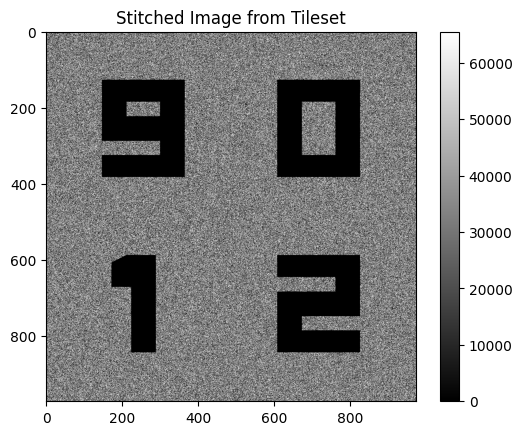

{'acquisition_date': '2025-07-15T18:03:09.543933',
 'channel_count': 1,
 'channels': [{'binning': 1,
               'emission_wavelength': None,
               'excitation_wavelength': 488.0,
               'exposure_time': 0.1,
               'gain': 1.0,
               'name': 'Channel-01',
               'objective_magnification': 100.0,
               'objective_numerical_aperture': 0.8,
               'objective_position': -0.01,
               'offset': 0.0,
               'power': 0.1}],
 'description': None,
 'filename': None,
 'pixel_size_x': 1e-07,
 'pixel_size_y': 1e-07,
 'pixel_size_z': None,
 'resolution': (973, 973),
 'stage_position': {'coordinate_system': 'RAW',
                    'name': 'stitched_mosaic_2x2',
                    'r': 0.0,
                    't': 0.0,
                    'x': 0.0,
                    'y': 0.0,
                    'z': 0.0},
 'system_info': None,
 'z_count': 1,
 'z_positions': None}


In [39]:
# plot the stitched image
plt.imshow(stitched_image.data, cmap='gray')
plt.title("Stitched Image from Tileset")
plt.colorbar()
plt.show()

pprint(stitched_image.metadata.to_dict())

#### Move to Microscope
Note: Need to take pre-caution when running this as it will insert the objective


In [ ]:
# requires integrated fibsem/fm microscope
from fibsem import utils
from fibsem.structures import BeamType
microscope, settings = utils.setup_session()


In [ ]:
# current orientation
orientation = microscope.get_stage_orientation()
print(f"Current Orientation: {orientation}")

if orientation != "FIB":
    microscope.move_flat_to_beam(BeamType.ION)

In [ ]:
microscope.move_to_microscope("FIBSEM")

print(f"Moved to FM orientation: {microscope.get_stage_orientation()}")

In [ ]:
print(microscope.get_stage_position())

#### Focus Stacking

In [ ]:
from fibsem.fm.calibration import create_block_based_focus_stack, create_pixel_based_focus_stack
import tifffile as tff
import matplotlib.pyplot as plt
import numpy as np

PATH = "/home/patrick/github/3DCT/3D_correlation_test_dataset/test-image2.ome.tiff"

image = tff.imread(PATH)
print(f"Image Shape: {image.shape}")

for i in range(image.shape[0]):
    print(f"Channel {i}: Shape {image[i].shape}")
    channel_data = image[i]
    stacked_image = create_block_based_focus_stack(channel_data, method='tenengrad', block_size=256, smooth_transitions=True)
    pixel_stacked_image = create_pixel_based_focus_stack(channel_data, method='tenengrad')
    fig, ax = plt.subplots(ncols=3, figsize=(15, 10))
    ax[0].imshow(np.max(channel_data, axis=0), cmap='gray')
    ax[0].set_title("Maximum Intensity Projection")
    ax[1].imshow(stacked_image, cmap='gray')
    ax[1].set_title("Focus Stack Projection")
    ax[2].imshow(pixel_stacked_image, cmap='gray')
    ax[2].set_title("Pixel-Based Focus Stack Projection")

    plt.tight_layout()
    plt.show()
